### 1. Import dependencies

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import class_weight
import pandas as pd
import os

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50, VGG16
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.
/home/abhijadhav/anaconda3/envs/lrp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/abhijadhav/anaconda3/envs/lrp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/abhijadhav/anaconda3/envs/lrp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/abhijadhav/

In [3]:
keras.__version__
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### 2. Create Keras data generators 

In [4]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    './data/cropped_split/train',
    batch_size=32,
    class_mode='binary',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    './data/cropped_split/val',
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))

Found 20211 images belonging to 2 classes.
Found 5120 images belonging to 2 classes.


In [5]:
df = pd.read_csv('data/ISIC_2019_Training_GroundTruth.csv')
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df['MEL'].to_numpy()),
                                                 df['MEL'].to_numpy())
print(class_weights)

[0.60865491 2.80086245]


/home/abhijadhav/anaconda3/envs/lrp/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 1. ... 1. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


### 3. Create the network

In [6]:
model_dir = 'models/keras/patience10_vgg16/'
patience = 10

In [7]:
conv_base = VGG16(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

In [8]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(conv_base.input, predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [9]:
optimizer = keras.optimizers.Adam()
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=patience),
             ModelCheckpoint(filepath= model_dir +'best_model.h5', monitor='val_loss', save_best_only=True)]

callbacks_ft = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath= model_dir +'best_model_ft.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

### 4. Train the model

In [10]:
history = model.fit_generator(generator=train_generator,
                              epochs=100,
                              validation_data=validation_generator, callbacks=callbacks, workers=4, class_weight=class_weights, )

Epoch 1/100
632/632 [==============================] - 272s 431ms/step - loss: 0.4106 - acc: 0.8397 - val_loss: 0.3673 - val_acc: 0.8533
Epoch 2/100
632/632 [==============================] - 116s 184ms/step - loss: 0.3547 - acc: 0.8573 - val_loss: 0.3566 - val_acc: 0.8562
Epoch 3/100
632/632 [==============================] - 121s 191ms/step - loss: 0.3368 - acc: 0.8624 - val_loss: 0.3366 - val_acc: 0.8586
Epoch 4/100
632/632 [==============================] - 125s 198ms/step - loss: 0.3296 - acc: 0.8632 - val_loss: 0.3357 - val_acc: 0.8627
Epoch 5/100
632/632 [==============================] - 127s 201ms/step - loss: 0.3215 - acc: 0.8669 - val_loss: 0.3430 - val_acc: 0.8621
Epoch 6/100
632/632 [==============================] - 128s 202ms/step - loss: 0.3151 - acc: 0.8693 - val_loss: 0.3372 - val_acc: 0.8643
Epoch 7/100
632/632 [==============================] - 128s 202ms/step - loss: 0.3063 - acc: 0.8748 - val_loss: 0.3543 - val_acc: 0.8633
Epoch 8/100
632/632 [====================

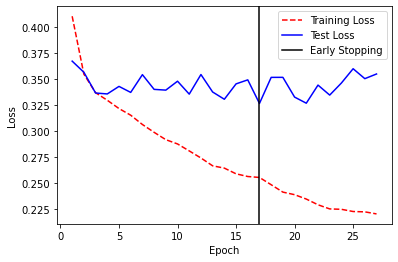

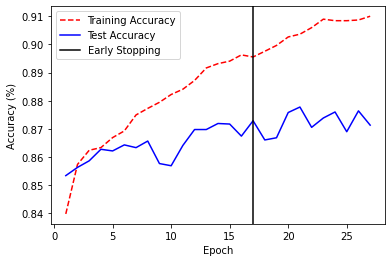

In [12]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.axvline(x=17, color='k')
plt.legend(['Training Loss', 'Test Loss', 'Early Stopping'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(model_dir + 'loss.png')

# Get training and test accuracy histories
training_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Visualize accuracy history
plt.figure(2)
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.axvline(x=17, color='k')
plt.legend(['Training Accuracy', 'Test Accuracy', 'Early Stopping'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.savefig(model_dir + 'acc.png')

In [ ]:
# Finetuning
model = load_model(model_dir + 'best_model.h5')
for layer in model.layers[-5:]:
    layer.trainable = True
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit_generator(generator=train_generator,
                              epochs=100,
                              validation_data=validation_generator, callbacks=callbacks_ft, workers=4, class_weight=class_weights)

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(model_dir + 'loss_ft.png')

# Get training and test accuracy histories
training_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize accuracy history
plt.figure(2)
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.savefig(model_dir + 'acc_ft.png')

### 5. Save and load the model

### 6. Make predictions on sample test images

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
best_model = load_model(model_dir + 'best_model.h5')
y_pred = best_model.predict_generator(validation_generator)[:,1]
y_actual = validation_generator.classes
fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
auc = roc_auc_score(y_actual, y_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(model_dir + 'roc_auc.png')

In [ ]:
best_model = load_model(model_dir + 'best_model_ft.h5')
y_pred = best_model.predict_generator(validation_generator)[:,1]
y_actual = validation_generator.classes
fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
auc = roc_auc_score(y_actual, y_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(model_dir + 'roc_auc_ft.png')

In [13]:
import innvestigate
import innvestigate.utils as iutils
import PIL
model = load_model(model_dir + 'best_model.h5')
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)
analyzer = innvestigate.create_analyzer("lrp.z", model_wo_softmax, neuron_selection_mode="index")

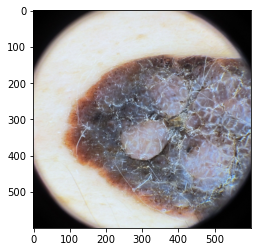

[[0.8318312  0.16816874]]


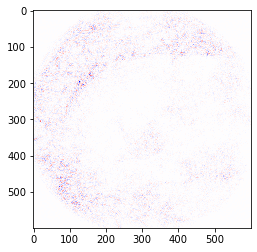

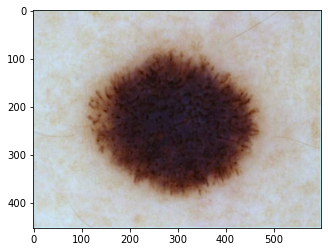

[[0.8611688  0.13883118]]


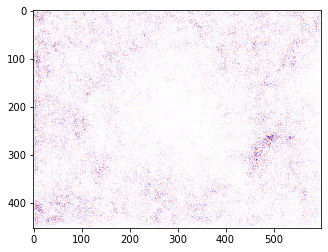

In [14]:
paths = ['data/cropped_split/val/positive/ISIC_0064863.jpg', 'data/cropped_split/val/negative/ISIC_0000199.jpg']
for path in paths:
    image = np.array(Image.open(path))
    expanded = np.expand_dims(image, axis=0)
    plt.imshow(image)
    plt.show()
    print(model.predict(expanded))
    a = analyzer.analyze(expanded, 1)
    a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
    a /= np.max(np.abs(a))
    # Plot
    plt.imshow(a[0], cmap="seismic", clim=(-1, 1))
    plt.show()

[[0.8318312  0.16816874]]


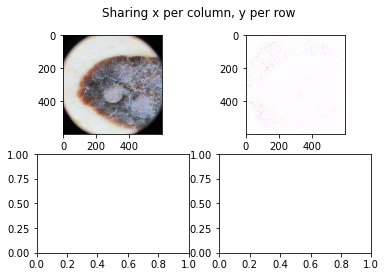

[[0.8611688  0.13883118]]


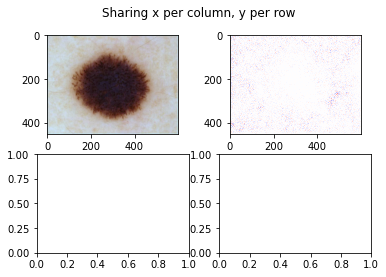

In [15]:
paths = ['data/cropped_split/val/positive/ISIC_0064863.jpg', 'data/cropped_split/val/negative/ISIC_0000199.jpg']
for path in paths:
    image = np.array(Image.open(path))
    expanded = np.expand_dims(image, axis=0)
    print(model.predict(expanded))
    a = analyzer.analyze(expanded, 1)
    a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
    a /= np.max(np.abs(a))
    # Plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    fig.suptitle('Sharing x per column, y per row')
    ax1.imshow(image)
    ax2.imshow(a[0], cmap="seismic", clim=(-1, 1))
    plt.show()

    for ax in fig.get_axes():
        ax.label_outer()